# Williams vs ATP Top 500
Group 18 Project Proposal by: Sandra Radic, Charlie Sushams, Alex Grinius, & Clare Vu

## Introduction

In the world of sports, events are often divided between males and females for fairness. Therefore, female and male statistics are not usually compared in one group. However, there are many outstanding female players that could very well pose as serious competition to the male dominated sport - 23-time Grand Slam champion Serena Williams is definitely one of them. Williams is ranked number 1 in women's tennis, and started her professional career in her early teenage years, reflecting her exceptional skill. This leads to our question: How would Serena Williams rank amongst the top 500 male players? Our group intends to analyze the factors that separate men's and women's sports, and use them in a classification model to predict which category (ranks from 1 - 501 players) Williams would fall under if she were to partake in a male-only tournament. To conduct this analysis, we will be using the Player Stats for Top 500 players dataset, from  https://www.ultimatetennisstatistics.com/. We will focusing on height, number of seasons played, and the age the player began their professional career. This will allow us to examine whether physical stature serves as a male advantage or not, and otherwise compares skill level. Consequently, we will be creating categories using the "best rank" column to further sort our data and choose a new rank level for Serena. 

## Preliminary exploratory data analysis:

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(scales)
library(stringr)
library(GGally)

Warning message:
"package 'tidyverse' was built under R version 4.0.5"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.5     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.0.5"
Warning message:
"package 'tibble' was built under R version 4.0.5"
Warning message:
"package 'tidyr' was built under R version 4.0.5"
Warning message:
"package 'readr' was built under R version 4.0.4"
Warning message:
"package 'dplyr' was built under R version 4.0.5"
Warning message:
"package 'stringr' was built under R version 4.0.5"
Warning message:
"package 'forcats' was built under R version 4.0.4"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks s

In [2]:
#read in data
player_stats_link <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
player_stats <- read_csv(player_stats_link)

head(player_stats)

Warning message:
"Missing column names filled in: 'X1' [1]"

-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)
i Use `spec()` for the full column specifications.




X1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,...,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Data Wrangling

**TODO** *insert methodology*

In [3]:
# select only the necessary columns

player_stats_filtered <- player_stats %>%
    select('Best Rank', 'Height', 'Seasons', 'Name', 'Turned Pro', 'Age') %>%
     drop_na()

# tidy up dataframe (ensure correct datatypes and appropriate column names)

player_stats_tidy <- player_stats_filtered %>%
    separate(col = Age, into = c("Age", "Birthdate"), sep = " ") %>%
# separate(col = Birthdate, into = c("Year born"), sep = "-") %>%
    mutate(Age = as.numeric(Age)) %>%
    mutate_at("Height", str_replace, " cm", "") %>%
    mutate(Height = as.numeric(Height)) %>%
    rename(Height_cm = Height, Year_turned_pro = "Turned Pro", Best_career_rank_to_date = "Best Rank")

player_stats_tidy$Best_career_rank_to_date <- gsub(" .+", "", player_stats_tidy$Best_career_rank_to_date)

#separate year from date

get_date <- as.Date(player_stats_tidy$Birthdate, "(%d-%m-%Y)")
get_year <- format(get_date, format = "%Y")

player_stats_tidy$Birthdate <- as.double(get_year)
player_stats_tidy <- mutate(player_stats_tidy, Best_career_rank_to_date = as.integer(Best_career_rank_to_date))

# create new column that lists a player's age when they turned pro

player_stats_tidy <- player_stats_tidy %>%
     mutate(Age_turned_pro = Year_turned_pro - Birthdate) %>%
    add_column(player_level = "NA") %>%
    arrange(desc(Best_career_rank_to_date))#adds new column for future categories

head(player_stats_tidy, 15)

Best_career_rank_to_date,Height_cm,Seasons,Name,Year_turned_pro,Age,Birthdate,Age_turned_pro,player_level
<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
183,183,8,Laurynas Grigelis,2008,28,1991,17,NA
169,183,5,Brydan Klein,2005,30,1989,16,NA
110,180,13,Peter Polansky,2007,31,1988,19,NA
99,180,10,Pedro Sousa,2007,31,1988,19,NA
98,180,7,Andrej Martin,2005,30,1989,16,NA
89,190,12,James Ward,2006,32,1987,19,NA
85,188,11,Matthias Bachinger,2005,32,1987,18,NA
84,183,7,Alessandro Giannessi,2008,29,1990,18,NA
82,183,9,James Duckworth,2010,28,1992,18,NA


**TODO** In order for us to conduct a classification analysis, we must have labelled categories to ...
Our end goal is to sort Serena Williams into one of these categories based on her statistics compared with our training model.

In [4]:
# Give ranks meaningi by sorting them into categories

for (row in 1:nrow(player_stats_tidy)) {
    rank <- pull(player_stats_tidy[row, "Best_career_rank_to_date"])
    if(rank < 11) {
        player_stats_tidy[row, "player_level"] = "top" 
    } else if(rank > 10 & rank < 41) {
        player_stats_tidy[row, "player_level"] = "great"
    } else {
        player_stats_tidy[row, "player_level"] = "good"
    }
}

player_stats_tidy <- player_stats_tidy %>%
    mutate(player_level = as.factor(player_level)) %>%
    arrange(desc(player_level))
tail(player_stats_tidy, 15)

Best_career_rank_to_date,Height_cm,Seasons,Name,Year_turned_pro,Age,Birthdate,Age_turned_pro,player_level
<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,178,11,Rogerio Dutra Silva,2003,35,1984,19,good
63,190,7,Bradley Klahn,2012,29,1990,22,good
62,178,10,Frederico Gil,2003,34,1985,18,good
57,178,11,Gastao Elias,2008,29,1990,18,good
56,193,11,Marius Copil,2008,29,1990,18,good
53,180,10,Denis Kudla,2010,27,1992,18,good
52,190,10,Igor Sijsling,2005,32,1987,18,good
51,196,13,Daniel Brands,2005,32,1987,18,good
50,175,13,Ricardas Berankis,2007,29,1990,17,good


**TODO** explain introduction of serena data

In [5]:
# create a dataframe for Serena Williams - currently contains junk data
serena_data <- data.frame(Best_career_rank_to_date = 1, Height_cm = 175, Seasons = 24, 
                          Name = "Serena Williams", Year_turned_pro = 1995, Age = 38, Birthdate = 1981,
                          Age_turned_pro = 14)

# serena_data sourced from: https://en.wikipedia.org/wiki/Serena_Williams

# Training the Classification Model
blahbalh

We will begin by splitting our training and testing data. In this analysis we will be using 70% of our data for training.

In [6]:
#split the player data into training and testing sets
set.seed(2021) #making sure data is reproducible

player_stats_split <- initial_split(player_stats_tidy, prop = 0.70, strata = player_level)

player_stats_training <- training(player_stats_split)
player_stats_testing <- testing(player_stats_split)



## Exploratory Data Analysis

**TODO**

**TODO** Justify visualization

Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


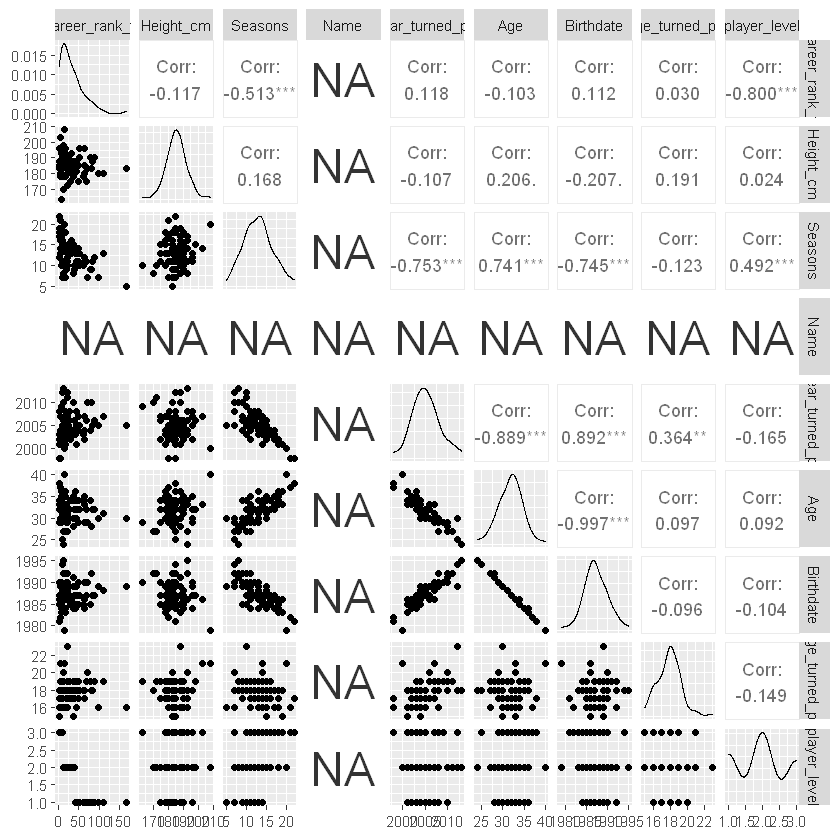

In [7]:
# options(repr.plot.width = 12, repr.plot.height = 12)

explore_plot <- player_stats_training %>%
    mutate_all(as.numeric) %>%
    ggpairs()
explore_plot #is there a way for us to remove name?

player_level,count,percentage,mean_height_cm,mean_number_pro_seasons,mean_age_turned_pro
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
good,22,30.13699,184.5909,10.95455,18.04545
great,32,43.83562,186.4062,12.68750,18.03125
top,19,26.02740,184.9474,15.68421,17.47368


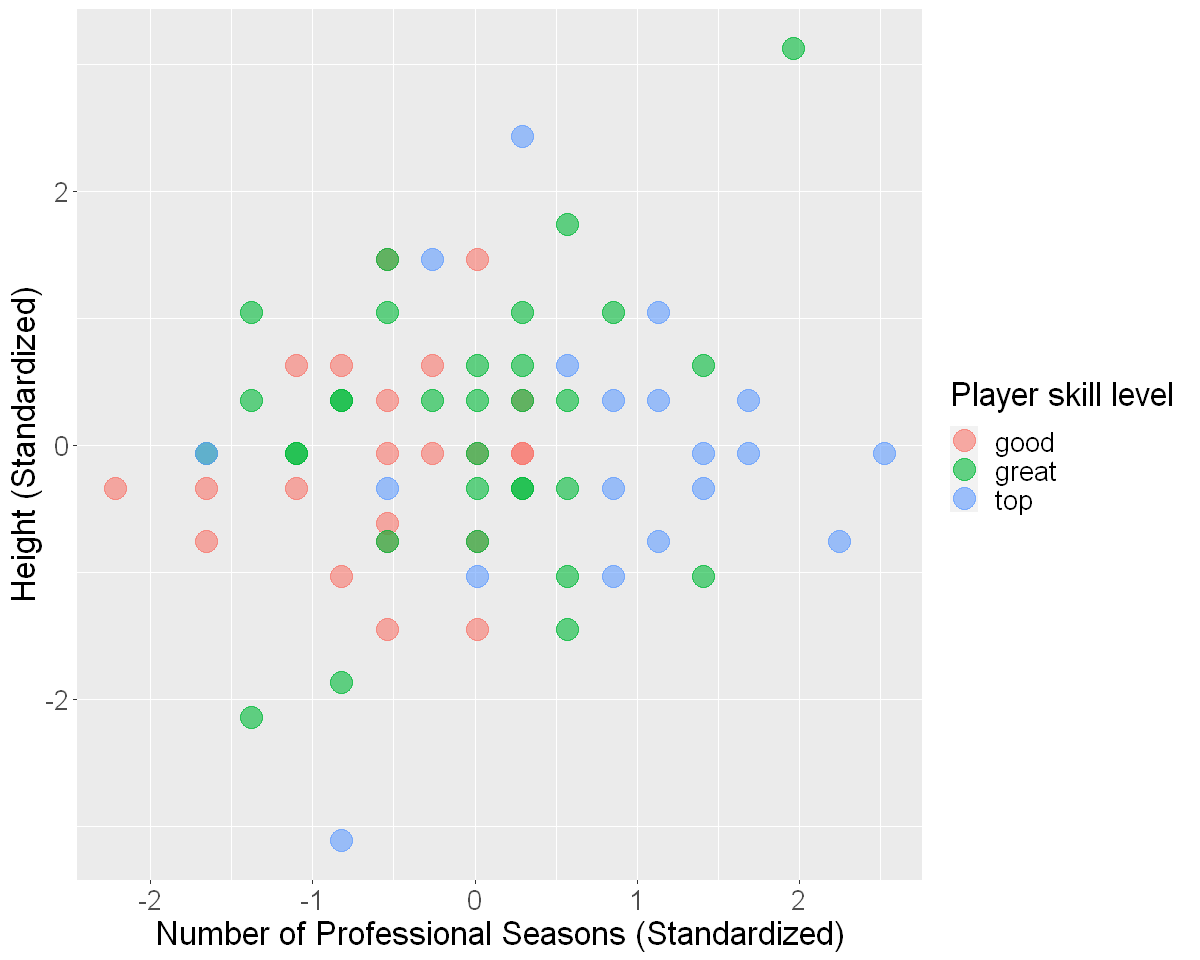

In [8]:
#create exploratory data frame that contains means of predictor variables

player_stats_exploratory <- player_stats_training %>%
    group_by(player_level) %>%
    summarize(count = n(),
              percentage = n() / nrow(player_stats_training) * 100,
              mean_height_cm = mean(Height_cm, na.rm = TRUE),
              mean_number_pro_seasons = mean(Seasons, na.rm = TRUE),
              mean_age_turned_pro = mean(Age_turned_pro, na.rm = TRUE))

player_stats_exploratory


seas_heigh_stats <- player_stats_training %>%
    select(Seasons, Height_cm, player_level)

seas_height_recipe <- recipe(player_level ~ ., data = seas_heigh_stats) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()

season_height_scaled <- bake(seas_height_recipe, seas_heigh_stats)

options(repr.plot.width = 10, repr.plot.height = 8)
seas_height_plot <- season_height_scaled %>%
    ggplot(aes(x = Seasons, y = Height_cm, colour = player_level)) +
    geom_point(alpha = 0.6, size = 6) +
    labs(x = "Number of Professional Seasons (Standardized)",
         y = "Height (Standardized)",
         colour = "Player skill level") +
    theme(text = element_text(size = 20))

seas_height_plot
#create plots to visualize training data
# options(repr.plot.width = 15, repr.plot.height = 10)
# height_v_rank <- ggplot(player_stats_training, aes(x = Best_career_rank_to_date, y = Height_cm)) +
#     geom_point(alpha = 0.6) +
#     xlab("Best Professional Career Rank") +
#     ylab("Height (cm)") +
#     ggtitle("Height compared to Best Ranking")

# seasons_v_rank <- ggplot(player_stats_training, aes(x = Best_career_rank_to_date, y = Seasons)) +
#     geom_point(alpha = 0.6) +
#     xlab("Best Professional Career Rank") +
#     ylab("Number of Season Played as a Professional") +
#     ggtitle("Seasons Played compared to Best Ranking")

# pro_age_v_rank <- ggplot(player_stats_training, aes(x = Best_career_rank_to_date, y = Age_turned_pro)) +
#     geom_point(alpha = 0.6) +
#     xlab("Best Professional Career Rank") +
#     ylab("Age When Player Turned Professional") +
#     ggtitle("Age turned pro compared to Best Ranking")

# plot_grid(height_v_rank, seasons_v_rank, pro_age_v_rank)

**TODO** Based on our independent variables compared wiht the best professional career rank, we predict...

**TODO** we make a confusion matrix to ...

In [9]:
set.seed(2021)
# center and scale data in recipe 
player_recipe <- recipe(player_level ~ + Height_cm + Seasons, data = player_stats_training) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())
player_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

## Cross-Validation

To begin our training with currently unknown value k, we use a 10-fold cross-validation.

In [10]:
set.seed(2021)
player_vfold <- vfold_cv(player_stats_training, v = 10, strata = player_level) #not 100% sure if i chose the right column

## Tuning our data

**TODO** We tune our data to help us visualize and decide which k-value provides the highest accuracy

In [11]:
set.seed(2021)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine('kknn') %>%
      set_mode('classification')

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 2))

player_results <- workflow() %>%
    add_recipe(player_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = player_vfold, grid = k_vals) %>%
    collect_metrics()

accuracies <- player_results %>%
    filter(.metric == "accuracy")
accuracies

Warning message:
"package 'rlang' was built under R version 4.0.5"
Warning message:
"package 'vctrs' was built under R version 4.0.5"
Warning message:
"package 'kknn' was built under R version 4.0.5"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4000000,10,0.05415467,Preprocessor1_Model01
3,accuracy,multiclass,0.4634921,10,0.06027103,Preprocessor1_Model02
5,accuracy,multiclass,0.4666667,10,0.07339828,Preprocessor1_Model03
7,accuracy,multiclass,0.4833333,10,0.07499848,Preprocessor1_Model04
9,accuracy,multiclass,0.4801587,10,0.05855173,Preprocessor1_Model05
11,accuracy,multiclass,0.4849206,10,0.05460833,Preprocessor1_Model06
13,accuracy,multiclass,0.5023810,10,0.06471540,Preprocessor1_Model07
15,accuracy,multiclass,0.4920635,10,0.07354307,Preprocessor1_Model08
17,accuracy,multiclass,0.5452381,10,0.06149926,Preprocessor1_Model09


visual

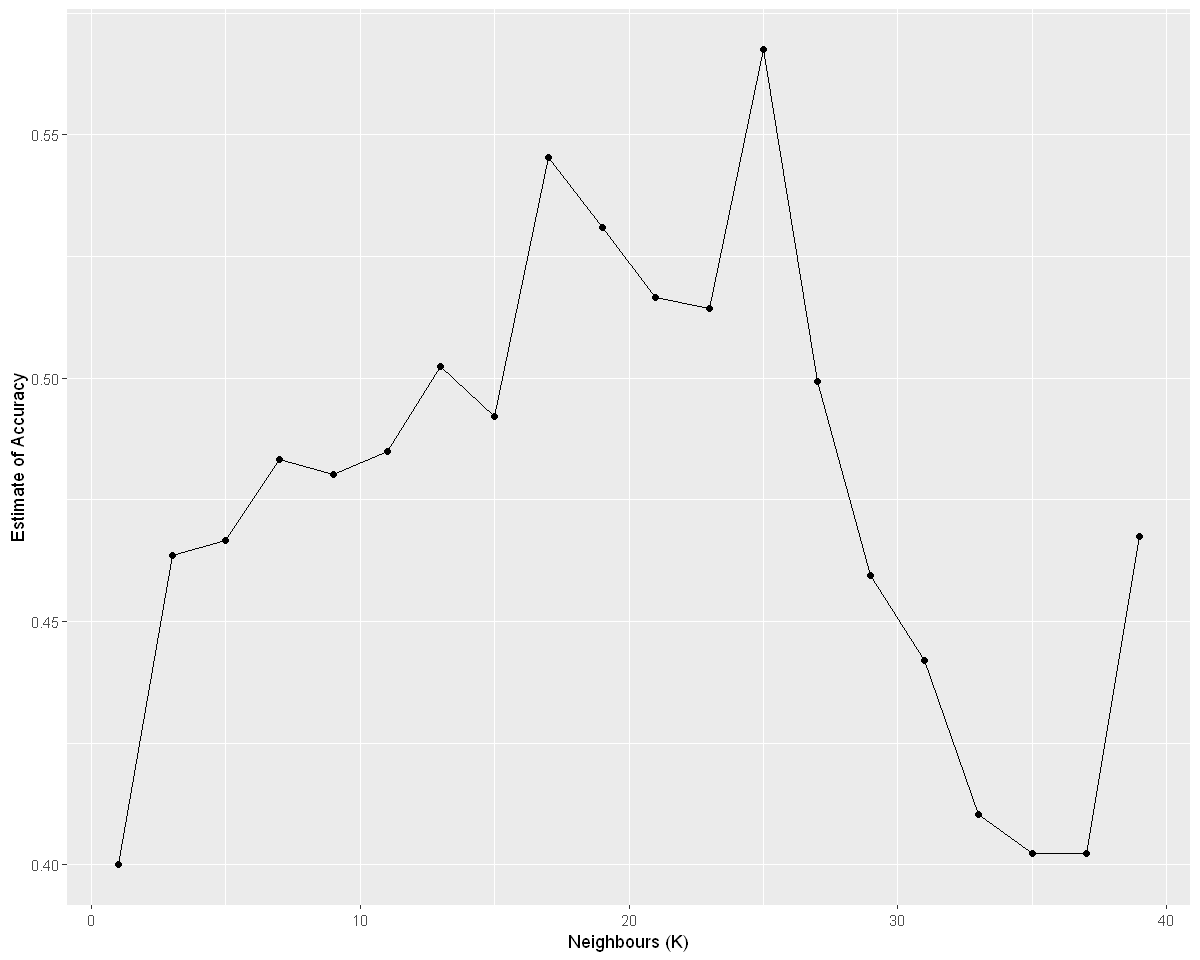

In [12]:
set.seed(2021)


cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                xlab("Neighbours (K)") +
                ylab("Estimate of Accuracy")
cross_val_plot

**TODO** k = 19. This value for K is selected because it provides roughly optimal accuracy (53% vs 57%) and changing the value to a nearby number of neighbours doesn't significantly change the accuracy, which makes our model more reliable in the presence of uncertainty. Conversely, choosing either 17 (55%) or 25 (57%) yields a higher accuracy, but changing k by a small amount leads to a significant change in accuracy, thus making the model less reliable.

**TODO** conduct and explain test predictions (NEED HELP HERE)

In [13]:
set.seed(2021)

player_tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) %>%
    set_engine("kknn") %>%
    set_mode("classification")

player_fit <- workflow() %>%
    add_recipe(player_recipe) %>%
    add_model(player_tuned_spec) %>%
    fit(data = player_stats_training)

player_test_predictions <- predict(player_fit, player_stats_testing) %>%
    bind_cols(player_stats_testing)

model_accuracy <- player_test_predictions %>%
    metrics(truth = player_level, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

model_accuracy

confusion <- player_test_predictions %>% 
      conf_mat(truth = player_level, estimate = .pred_class)

confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5588235


          Truth
Prediction good great top
     good     7     1   0
     great    3    11   8
     top      0     3   1

New names:
* NA -> ...4



Height_cm,Seasons,player_level,...4
<dbl>,<dbl>,<fct>,<chr>
-1.42267,2.877747,top,Serena Williams


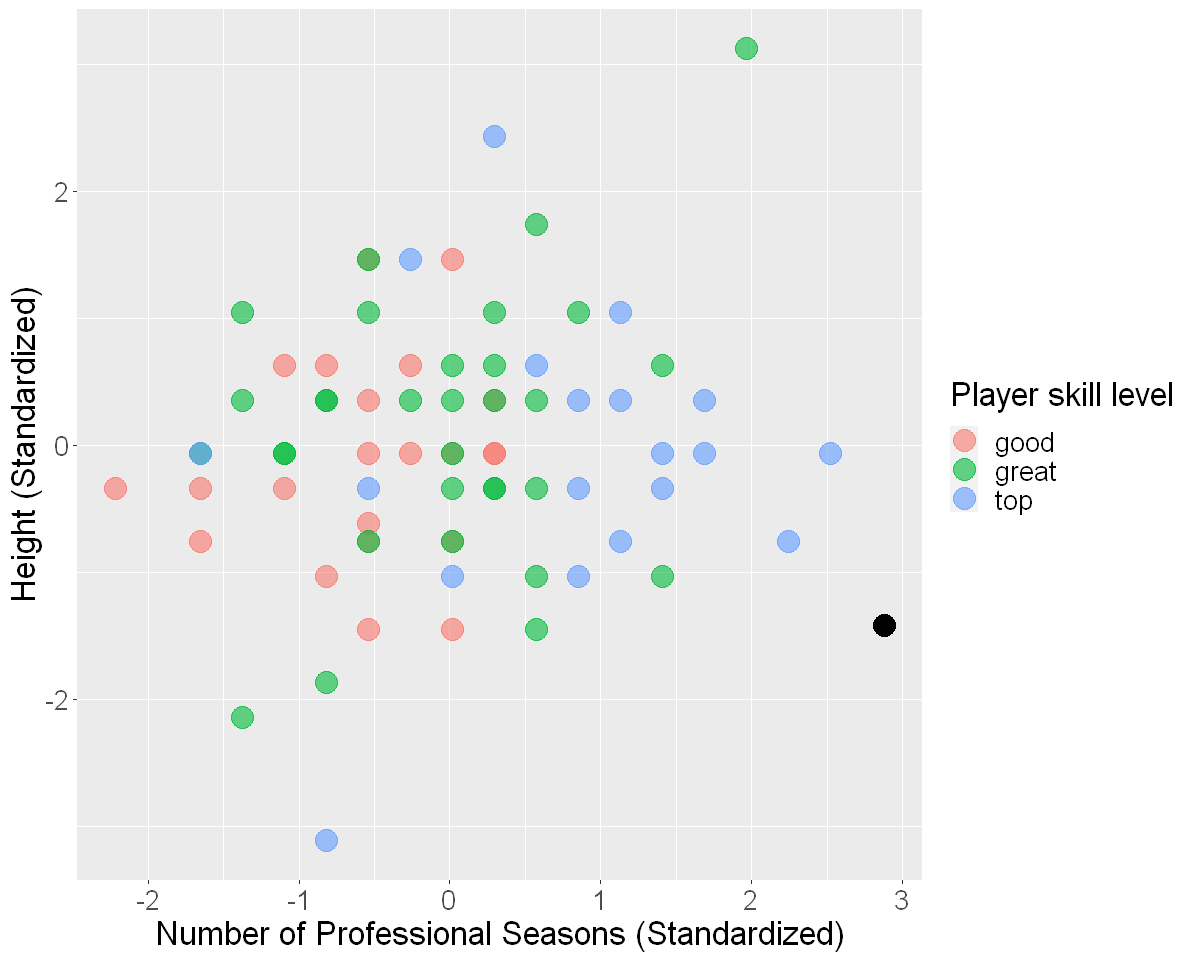

In [33]:
#predict Player Level for Serena Williams

serena_prediction <- predict(player_fit, serena_data) %>%
bind_cols(serena_data)

serena_prediction <- serena_prediction %>%
    rename(player_level = .pred_class)

#graph location of serena point

player_training_with_serena <- rbind(player_stats_training, serena_prediction)


serena_recipe <- recipe(player_level ~ + Height_cm + Seasons, data = player_training_with_serena) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors()) %>%
   prep()

serena_standardized <- bake(serena_recipe, player_training_with_serena) %>%
     bind_cols(player_training_with_serena$Name)

serena_standardized <- serena_standardized %>%
    filter(...4 == "Serena Williams")
serena_standardized

options(repr.plot.width = 10, repr.plot.height = 8)
seas_height_plot +
    geom_point(aes(x = 2.877747, y = -1.42267), colour = "black", size = 6)


## Methods

To tidy our data, we will first subset our dataset to contain columns of interest such as "Height", "Age", "Seasons" and "Rank". We will be creating an additional column "Age turned pro", calculated as "Year turned pro" subtracting "Birthdate", to calculate the difference in years and find out how old players were at the start of their professional career. A separate dataframe will be created that contains matching information on Serena Williams.

As mentioned in our introduction, we will be creating a classification model by filtering intervals from the "Best Rank" column as categories. Players ranked in the top 10 will be defined as Top Players, players ranked between 11-30 will be Competitive Players, players ranked between 31 - 50 will be Great players, players ranked between 51-100 will be Good players, and the rest will be considered Average Players. The goal is to place Serena Williams in one of these categories by the end of our analysis. 

We plan to visualize our data by plotting the various potential predictors, such as Height, Number of Seasons played, and Age when the player turned professional, against their best rank achieved (in 2019) to determine whether any relationships exist. 


## Expected Outcomes and Significance

In this analysis, we expect to find that Serena Williams' skill and experience that come from her early age of turning pro as well as the number of seasons she played will cause her to rank highly amongst men - however, not nearly as highly as in female statistics. We expect her shorter height may be a disadvantage next to males that could affect her rank. This will help us determine whether early exposure to a professional career can overcome the disadvantage of a smaller body type.  

This exploration will be impactful in showing us how males and females are separated in sports, and to see to what extend physical stature serves as an advantage to men. From a feminist standpoint, it could also be impactful in showing female athletes can be put up against men fairly. In future studies, we could compare more female professionals with males and conduct combined tournaments to gain new statistics and see how much ranking is affected when athletes intermingle, rather than comparing only male-male and female-female stats. 
